In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from google.colab import drive
import matplotlib.pyplot as plt

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Path dataset di Google Drive
data_dir = '/content/drive/My Drive/dataset/skin'

# Folder untuk train dan validation
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'testing')

def count_images(directory):
    category_counts = {}
    for category in sorted(os.listdir(directory)):
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            category_counts[category] = len(os.listdir(category_path))
    return category_counts

train_distribution = count_images(train_dir)
test_distribution = count_images(test_dir)

print("Distribusi dataset training:", train_distribution)
print("Distribusi dataset validasi:", test_distribution)

# Parameter preprocessing
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Distribusi dataset training: {'Acne': 1846, 'Actinic Keratosis': 1854, 'Basal Cell Carcinoma': 1846, 'Eczemaa': 1844, 'Normal': 1816}
Distribusi dataset validasi: {'Acne': 777, 'Actinic Keratosis': 775, 'Basal Cell Carcinoma': 776, 'Eczemaa': 774, 'Normal': 504}


In [ ]:
# Augmentasi untuk data training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocessing data validation
test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 9206 images belonging to 5 classes.
Found 3606 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,431,045 (9.27 MB)

 Trainable params: 172,805 (675.02 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [ ]:
# Kompilasi model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Learning rate kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Membuka layer dari index tertentu
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [ ]:
# Kompilasi ulang dengan learning rate kecil
model.compile(optimizer=Adam(learning_rate=1e-5),  # Fine-tuning membutuhkan learning rate lebih kecil
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [ ]:
# Training model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


288/288 ━━━━━━━━━━━━━━━━━━━━ 3744s 13s/step - accuracy: 0.2075 - loss: 6.3653 - val_accuracy: 0.2940 - val_loss: 5.4353 - learning_rate: 1.0000e-05
Epoch 2/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 929s 3s/step - accuracy: 0.2776 - loss: 5.8463 - val_accuracy: 0.3331 - val_loss: 5.3581 - learning_rate: 1.0000e-05
Epoch 3/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 954s 3s/step - accuracy: 0.3321 - loss: 5.4534 - val_accuracy: 0.4201 - val_loss: 4.9638 - learning_rate: 1.0000e-05
Epoch 4/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 986s 3s/step - accuracy: 0.3899 - loss: 5.1401 - val_accuracy: 0.4859 - val_loss: 4.7051 - learning_rate: 1.0000e-05
Epoch 5/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 952s 3s/step - accuracy: 0.4183 - loss: 4.9065 - val_accuracy: 0.5449 - val_loss: 4.4969 - learning_rate: 1.0000e-05
Epoch 6/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 938s 3s/step - accuracy: 0.4575 - loss: 4.7595 - val_accuracy: 0.6015 - val_loss: 4.2967 - learning_rate: 1.0000e-05
Epoch 7/40
288/288 ━━━━━━━━━━━━━━━━━━━━ 1012s 3s/step - accuracy: 0

In [ ]:
model.save('final_model.h5')

In [ ]:
from google.colab import files

# Unduh file model ke lokal
files.download('final_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluasi model pada dataset validasi
loss, accuracy = model.evaluate(test_generator)
print(f"Validation Accuracy: {accuracy*100:.2f}%")


113/113 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - accuracy: 0.8392 - loss: 2.5874
Validation Accuracy: 83.39%


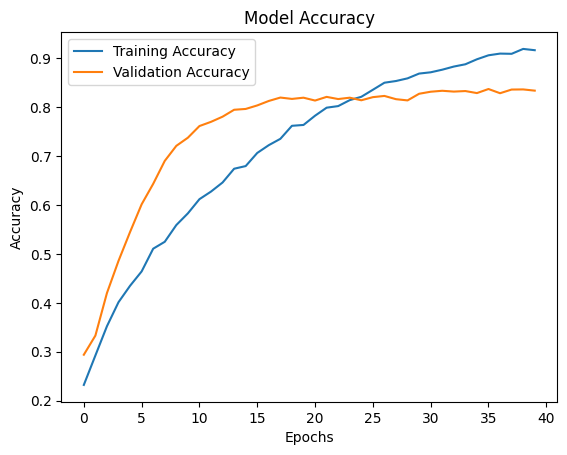

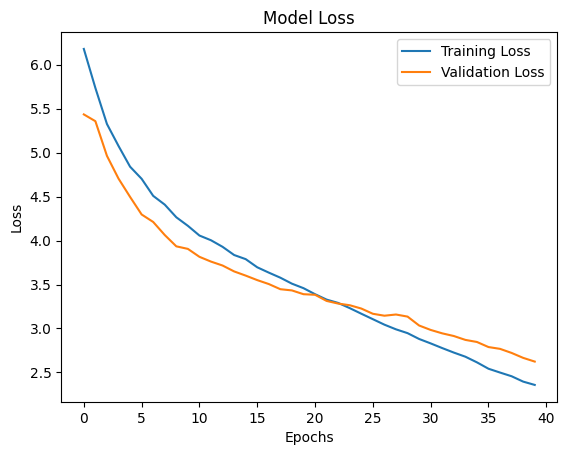

In [ ]:
# Plot akurasi
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [ ]:
from google.colab import files

# Unggah model dari komputer lokal
uploaded = files.upload()

Saving final_model (2).h5 to final_model (2).h5


In [ ]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('final_model (2).h5')


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image(image_path, img_size=(224, 224)):
    """
    Preprocessing gambar dari lokal.
    - Resize gambar ke ukuran yang diinginkan.
    - Normalisasi pixel menjadi nilai antara 0-1.
    - Tambahkan dimensi batch untuk prediksi model.

    Args:
    image_path (str): Path ke gambar.
    img_size (tuple): Ukuran gambar (height, width).

    Returns:
    numpy.ndarray: Array gambar yang sudah diproses.
    """
    img = load_img(image_path, target_size=img_size)  # Load dan resize gambar
    img_array = img_to_array(img)  # Konversi ke array
    img_array = img_array / 255.0  # Normalisasi nilai pixel
    img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension
    return img_array

Saving download.jpg to download.jpg
Gambar berhasil diunggah: download.jpg


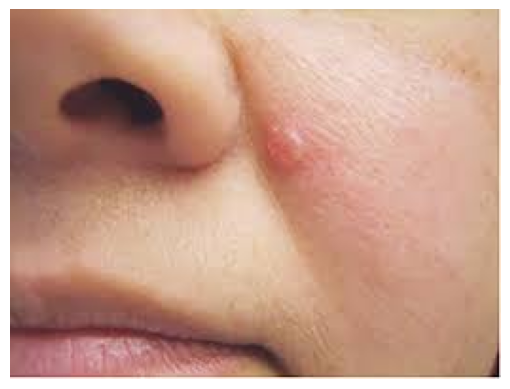

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Hasil prediksi: Eczemaa


In [ ]:
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Unggah file dari komputer
uploaded = files.upload()

# Ambil path dari file yang diunggah
image_path = list(uploaded.keys())[0]  # Nama file yang diunggah
print(f"Gambar berhasil diunggah: {image_path}")

# Load gambar asli untuk ditampilkan
img = load_img(image_path)

# Tampilkan gambar dan hasil prediksi
plt.imshow(img)
plt.axis('off')
plt.show()

# Preprocess gambar
img_array = preprocess_image(image_path)

# Prediksi
prediction = model.predict(img_array)

# Konversi hasil prediksi menjadi label
class_labels = ['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Normal']  # Sesuaikan label dengan dataset Anda
predicted_class = np.argmax(prediction, axis=1)[0]

# Tampilkan hasil prediksi
print(f"Hasil prediksi: {class_labels[predicted_class]}")

In [ ]:
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('final_model (2).h5')

# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model has been successfully converted to TFLite format.")

Saved artifact at '/tmp/tmp_f6txxtx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  140594038271920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038365472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038367584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038360896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038363184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038371104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038371456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038372864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038369344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140594038370752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1405940383716